In [1]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

Experiment: 0
True coef:(0: 1.00), (1: 1.00)
early stopping at iter:2240
Direct coef:(0: 0.80), (1: 0.81)
early stopping at iter:1113
early stopping at iter:793
0.0230258509299
0.0126863624118
early stopping at iter:602
CrossOrtho coef:(0: 0.86), (1: 0.86)


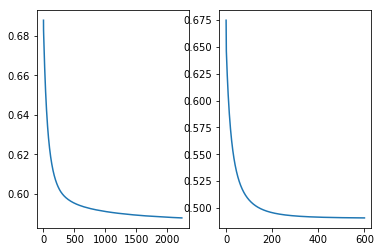

Experiment: 1
True coef:(0: 1.00), (3: 1.00)
early stopping at iter:2490
Direct coef:(0: 0.84), (3: 0.78)
early stopping at iter:990
early stopping at iter:964
0.0230258509299
0.0126863624118
early stopping at iter:672
CrossOrtho coef:(0: 0.93), (3: 0.86)


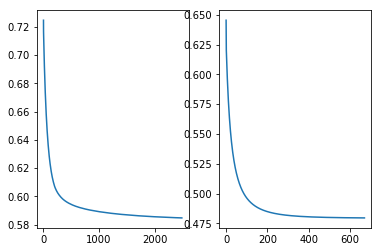

Experiment: 2
True coef:(1: 1.00), (2: 1.00)
early stopping at iter:2219
Direct coef:(1: 0.77), (2: 0.82)
early stopping at iter:855
early stopping at iter:1467
0.0230258509299
0.0126863624118
early stopping at iter:653
CrossOrtho coef:(1: 0.84), (2: 0.89)


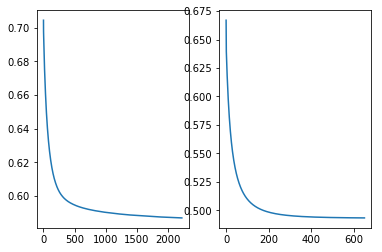

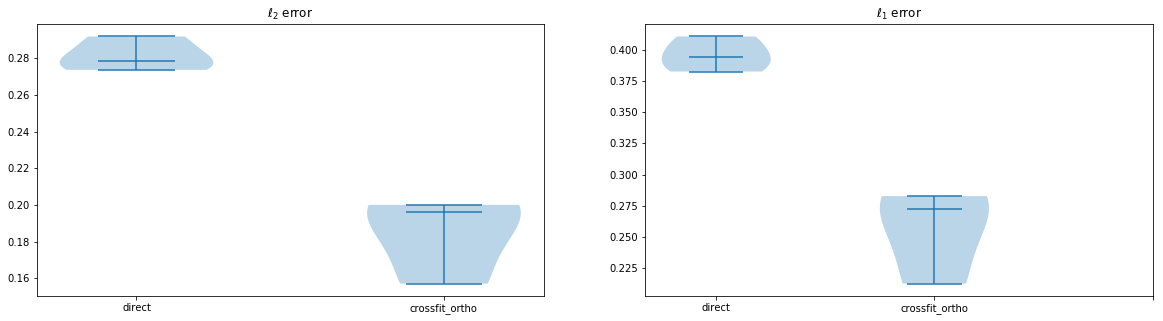

In [13]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from logistic_te import gen_data, direct_fit, dml_crossfit


def main():
    opts= {'n_experiments': 3, # number of monte carlo experiments
            'n_samples': 10000, # samples used for estimation
            'dim_x': 100, # dimension of controls x
            'dim_z': 5, # dimension of variables used for heterogeneity (subset of x)
            'kappa_theta': 2, # support size of target parameter
            'kappa_x': 5, # support size of nuisance
            'sigma_eta': 3, # variance of error in secondary moment equation
            'sigma_x': .5, # variance parameter for co-variate distribution
            'lambda_coef': .5, # coeficient in front of the asymptotic rate for regularization lambda
            'steps': 10000, # max iter for gradient based logistic regression
            'lr': 0.05, # constant learning rate for gradient based regression
            'lr_schedule': 'constant', # constant or decay
            'bs': 10000, # batch size for SGD training
            'n_folds': 2, # number of folds used in cross-fitting
    }
    
    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for step in range(opts['n_experiments']):
        print("Experiment: {}".format(step))
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(opts['n_samples'], opts['dim_x'], opts['dim_z'], opts['kappa_x'],\
                        opts['kappa_theta'], opts['sigma_eta'], opts['sigma_x'])
        true_coef = np.zeros((opts['dim_z'], 1))
        true_coef[support_theta] = theta
        print('True coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(true_coef.flatten()) if c>0.001]))
        
        # Direct lasso for all coefficients
        model_y, model_t= direct_fit(x, t, z, y, opts)
        direct_coef = model_y.coef_.flatten()[:z.shape[1]]
        print('Direct coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(direct_coef) if c>0.001]))
        l1_direct.append(np.linalg.norm(direct_coef - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(direct_coef - true_coef.flatten(), ord=2))
        
        # Crossfit Orthogonal lasso estimation
        model_dml = dml_crossfit(x, t, z, y, opts)
        ortho_coef = model_dml.coef_.flatten()
        l1_cross_ortho.append(np.linalg.norm(ortho_coef.flatten() - true_coef.flatten(), ord=1))
        l2_cross_ortho.append(np.linalg.norm(ortho_coef.flatten() - true_coef.flatten(), ord=2))
        print('CrossOrtho coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(ortho_coef) if c>0.001]))
        plt.figure()
        plt.subplot(1,2,1)
        plt.plot(model_y.training_cost_)
        plt.subplot(1,2,2)
        plt.plot(model_dml.training_cost_)
        plt.show()
        

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct), np.array(l2_cross_ortho)], showmedians=True)
    plt.xticks([1,2], ['direct', 'crossfit_ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct), np.array(l1_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'crossfit_ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()